In [1]:
import os
import shutil
import argparse
import time

import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

import pandas as pd
import numpy as np

In [2]:
state = torch.load("runs/f-a.00002-adm-0/model_best.pth.tar")

In [3]:
class MarketLSTM(nn.Module):
    def __init__(self, hidden_dim):
        super(MarketLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(1, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)).cuda().double(),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)).cuda().double())

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(
            input.view(-1, 1, 1), self.hidden)
        outputs = self.fc(lstm_out)
        return outputs

In [4]:
model = MarketLSTM(100).cuda().double()

In [5]:
model.load_state_dict(state['state_dict'])

In [6]:
from dataloader_2017 import all_loader

In [7]:
loader = all_loader()

In [85]:
import matplotlib.pyplot as plt

In [203]:
tensor = next(iter(loader))

In [204]:
model.zero_grad()
model.hidden = model.init_hidden()
input = torch.autograd.Variable(tensor[2].cuda())
output = model(input)
out = output.cpu().data.numpy().reshape([-1])

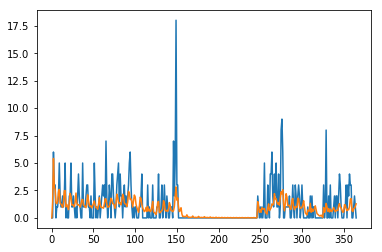

In [205]:
plt.plot(np.expm1(tensor[2][0].numpy()))
plt.plot(np.expm1(out))
plt.show()

In [8]:
test = pd.read_csv("../csv/test.csv")

In [9]:
sub = pd.read_csv("../csv/ensemble.csv")

In [61]:
print(sub.tail())

           unit_sales
id                   
128867499         0.0
128867500         0.0
128867501         0.0
128867502         0.0
128867503         0.0


In [10]:
target_dates = pd.date_range("2017-08-16", "2017-08-31")

In [11]:
test.set_index(["item_nbr", "store_nbr", "date"], inplace=True)
sub.set_index(["id"], inplace=True)

In [ ]:
_loader = all_loader()

In [219]:
test[(test['store_nbr']==54) & (test['item_nbr']==2132163) & (test['date']=='2017-08-31')]['id'].as_matrix()[0]

128867499

In [ ]:
for i, (store, item, data) in enumerate(_loader):
    model.hidden = model.init_hidden()
    store = store[0]
    item = item[0]
    input = torch.autograd.Variable(data.cuda())
    output = model(input)
    out = output.cpu().data.numpy().reshape([-1])[-1]
    try:
        for d in target_dates:
            d = d.strftime('%Y-%m-%d')
            out_id = test.loc[item, store, d]['id']
            sub.loc[out_id]["unit_sales"] = np.expm1(out)
            output = model(torch.autograd.Variable(torch.DoubleTensor([out]).cuda()))
            out = output.cpu().data.numpy().reshape([-1])[-1]
    except:
        a = 0

In [15]:
sub[sub['unit_sales']<0] = 0

In [17]:
sub.to_csv("lstm.csv")

In [38]:
np.expm1(-1)

-0.63212055882855767

In [14]:
5

5